<a href="https://colab.research.google.com/github/TheoBacqueyrisse/Graph-Neural-Networks/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks with Molecules

<div style="display: flex;">
    <img src="https://pytorch-geometric.readthedocs.io/en/1.6.1/_static/pyg_logo_text.svg" alt="Image 1" width= "500" margin-right= "100"/>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/L-glyceraldehyde-3D-balls.png/694px-L-glyceraldehyde-3D-balls.png?20061012175424" alt="Image 2" width= "250" />
</div>

In [2]:
# Let us first clone the GitHub repository
%%capture
!git clone https://github.com/TheoBacqueyrisse/Graph-Neural-Networks.git

In [3]:
# Install dependencies
%%capture
!pip install -r /content/Graph-Neural-Networks/requirements.txt

In [24]:
# Import Packages
import pandas
import numpy as np
import torch
from torch_geometric.datasets import ZINC

# Visualisation
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loader
from torch_geometric.loader import DataLoader

# Neural Network Architecture
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn import global_max_pool as gmp, global_mean_pool as gap

# Loss Function
from torch.nn import MSELoss

# Optimizer
from torch.optim import Adam

# See the progression of the Training
import tqdm

## Load ZINC Dataset ⏳

In [5]:
zinc = ZINC('/content/Graph-Neural-Networks/data')

Extracting /content/Graph-Neural-Networks/data/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 5000/5000 [00:00<00:00, 5744.58it/s]
Done!


## Investigation of the Data  🔎

In [6]:
print("General Info on the Data : ")
print(60*'-')
print("Number of Graphs in the Data : ", zinc.len())
print("Number of Features in the Data : ", zinc.num_features)
print("Example : ", zinc[0])

General Info on the Data : 
------------------------------------------------------------
Number of Graphs in the Data :  220011
Number of Features in the Data :  1
Example :  Data(x=[33, 1], edge_index=[2, 72], edge_attr=[72], y=[1])


In [7]:
ex = zinc[0]
ex

Data(x=[33, 1], edge_index=[2, 72], edge_attr=[72], y=[1])

In [8]:
#
ex.x

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [2],
        [2],
        [0],
        [2],
        [0],
        [0],
        [0],
        [0],
        [0],
        [2],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [2],
        [0],
        [5]])

In [9]:
# The Edge Indexes show what Nodes Interact with each other
ex.edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 6, 32],
        [ 7,  6],
        [ 7,  8],
        [ 8,  7],
        [ 8,  9],
        [ 8, 31],
        [ 9,  8],
        [ 9, 10],
        [ 9, 11],
        [10,  9],
        [11,  9],
        [11, 12],
        [11, 28],
        [12, 11],
        [12, 13],
        [13, 12],
        [13, 14],
        [13, 27],
        [14, 13],
        [14, 15],
        [14, 16],
        [15, 14],
        [16, 14],
        [16, 17],
        [16, 25],
        [17, 16],
        [17, 18],
        [17, 23],
        [18, 17],
        [18, 19],
        [19, 18],
        [19, 20],
        [20, 19],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [23, 17],
        [23, 22],
        [23, 24],
        [24, 23],
        [2

In [10]:
ex.edge_attr

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1,
        1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1])

In [11]:
# That is our target variable, the Penalized logP
ex.y

tensor([3.0464])

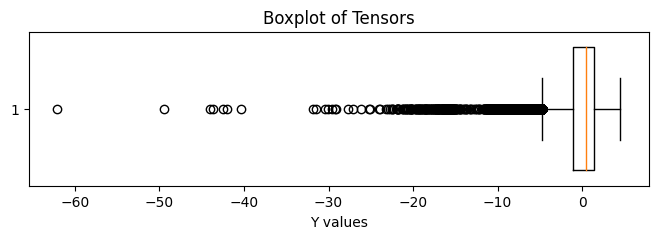

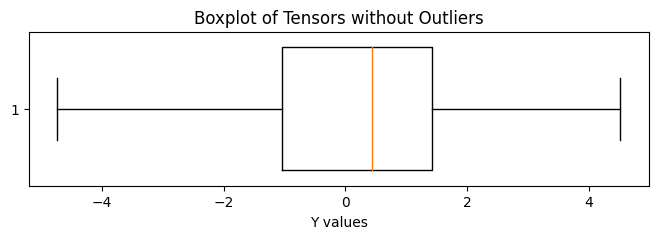

In [12]:
# Set the Target Tensors in zinc to a Numpy Array
targets = np.concatenate([zinc[i].y.numpy() for i in range(len(zinc))]).flatten()

# Boxplot of the Y values
plt.figure(figsize=(8, 2))
plt.boxplot(targets, vert = False, widths = 0.8)
plt.xlabel('Y values')
plt.title('Boxplot of Tensors')
plt.show()

# Boxplot of the Y values but not showing Outliers
plt.figure(figsize=(8, 2))
plt.boxplot(targets, vert = False, widths = 0.8, showfliers=False)
plt.xlabel('Y values')
plt.title('Boxplot of Tensors without Outliers')
plt.show()

We can create a function designed to plot a visual representation of a graph from the ZINC dataset, given its index.

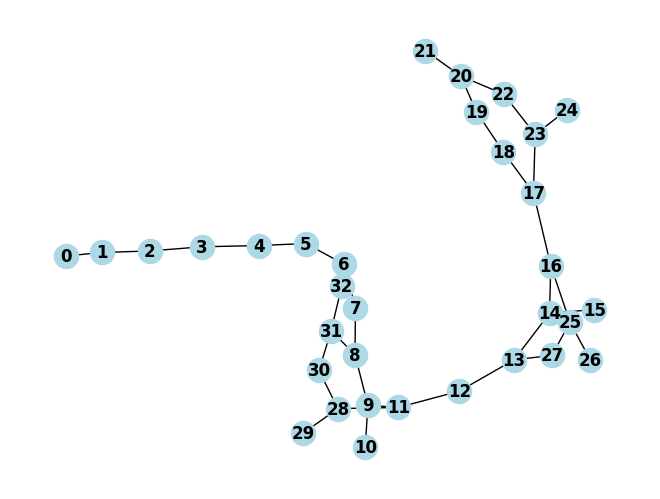

In [13]:
def graph_representation(index_zinc):
  G = nx.Graph()

  # Add nodes to the graph plot
  for i in range(zinc[index_zinc].num_nodes):
      G.add_node(i)

  # Add edges to the NetworkX graph
  edge_index = zinc[index_zinc].edge_index.t().numpy()
  edges = [(edge[0], edge[1]) for edge in edge_index]
  G.add_edges_from(edges)

  return G


nx.draw(graph_representation(0), with_labels=True, node_color='lightblue', font_weight='bold')

However, we see here a property of graphs, that is the change in their structure


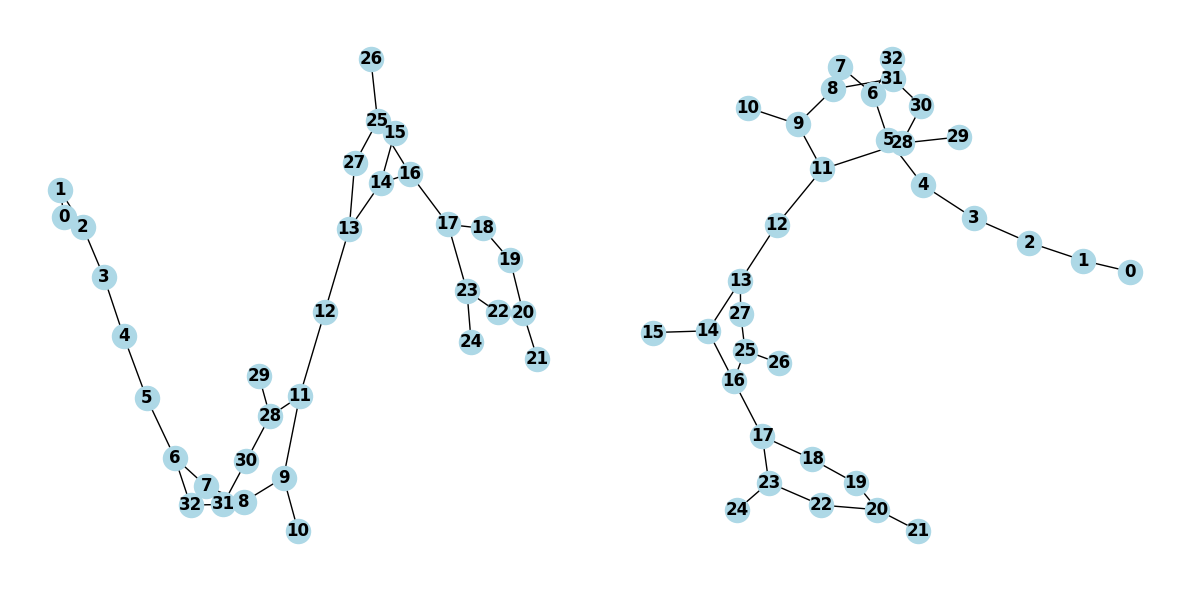

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(graph_representation(0), with_labels=True, node_color='lightblue', font_weight='bold')

plt.subplot(1, 2, 2)
nx.draw(graph_representation(0), with_labels=True, node_color='lightblue', font_weight='bold')

plt.tight_layout()
plt.show()

## Graph Neural Network Module

In [18]:
embedding = 64

In [25]:
class GNN(torch.nn.Module):
    def __init__(self):
      super(GNN, self).__init__()

      # Care about the design of the NN here
      self.initial_conv = GCNConv(in_channels = 1, out_channels = embedding)
      self.conv_layer1 = GCNConv(in_channels = embedding, out_channels = embedding)
      self.conv_layer2 = GCNConv(in_channels = embedding, out_channels = embedding)
      self.conv_layer3 = GCNConv(in_channels = embedding, out_channels = embedding)

      self.out = Linear(in_features = embedding, out_features = 1)

    def forward(self, x, edge_index, batch_index):
      #Also inclue Dropout / Pooling at the end + others
      y = self.initial_conv(x, edge_index)
      y = F.relu(y)
      y = self.conv_layer1(y, edge_index)
      y = F.relu(y)
      y = self.conv_layer2(y, edge_index)
      y = F.relu(y)
      y = self.conv_layer3(y, edge_index)


      # Pooling Layer here
      y = gap(y)

      out = self.out(y)

      return out, y

model = GNN()
print(model)

GNN(
  (initial_conv): GCNConv(1, 64)
  (conv_layer1): GCNConv(64, 64)
  (conv_layer2): GCNConv(64, 64)
  (conv_layer3): GCNConv(64, 64)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


## Use Available Google GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Data Loaders

In [ ]:
nb_graphs_per_batch = 128

train_loader = DataLoader(zinc[:int(len(zinc)*0.7)],
                          batch_size = nb_graphs_per_batch,
                          shuffle = True)

val_loader = DataLoader(zinc[int(len(zinc)*0.7):int(len(zinc)*0.8)],
                        batch_size = nb_graphs_per_batch,
                        shuffle = False)

test_loader = DataLoader(zinc[int(len(zinc)*0.8):],
                         batch_size = nb_graphs_per_batch,
                         shuffle = False)

In [ ]:
print("Number of Batches in Train Loader :", len(train_loader))
print("Number of Batches in Val Loader :", len(val_loader))
print("Number of Batches in Test Loader :", len(test_loader))

Number of Batches in Train Loader : 1204
Number of Batches in Val Loader : 172
Number of Batches in Test Loader : 344


## Loss and Optimizer

In [ ]:
loss = MSELoss()
optimizer = Adam(params = model.parameters, lr = 0.05)

## Training Phase 🚀

In [ ]:
NUM_EPOCHS = 10
